<a href="https://colab.research.google.com/github/krisMG21/PL1_IA/blob/main/PEC1_Grupo10_C%C3%B3digo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Descargar base de datos desde repositorio de github:

El archivo que se descarga es idéntico al aportado en la práctica, pero si se desea, se puede subir manualmente, como `data/Datos_credito.csv`, o `Datos_credito.csv` en el directorio actual

In [68]:
# si no existe en local, descargar data/Datos_credito.csv desde el repo krisMG21/PL1_IA en github

import os
import requests

if not os.path.exists('data/Datos_credito.csv'):
  os.makedirs('data', exist_ok=True)
  url = 'https://raw.githubusercontent.com/krisMG21/PL1_IA/main/data/Datos_credito.csv'
  response = requests.get(url)
  with open('data/Datos_credito.csv', 'wb') as f:
    f.write(response.content)
  print('Datos_credito.csv descargado.')
else:
  print('Datos_credito.csv ya existe en local.')


Datos_credito.csv ya existe en local.


## Importar librerías y definir funciones:

In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

"""
pandas y numpy: Se utilizan para manipulación de datos y operaciones numéricas, respectivamente.
StandardScaler: Permite estandarizar características restando la media y escalando a varianza unitaria.
KNeighborsClassifier: Implementa el algoritmo de clasificación k-vecinos más cercanos (KNN).
confusion_matrix: Función de scikit-learn que calcula la matriz de confusión para evaluar el rendimiento del modelo.
matplotlib y seaborn: Librerías de visualización que permiten mostrar gráficas y mapas de calor, como la matriz de confusión.
"""

def percentage_predicted_cm(cm):
  """
  Procesa la matriz de confusión convirtiendo los valores absolutos en porcentajes, con respecto al total de esa predicción.
  - cm: Matriz de confusión.
  """
  # Matriz en float
  cm = cm.astype("float")

  # Matriz en porcentajes
  cm[:,0] /= cm[:,0].astype("float").sum()
  cm[:,1] /= cm[:,1].astype("float").sum()
  cm *= 100
  return cm

def percentage_real_cm(cm):
  """
  Procesa la matriz de confusión convirtiendo los valores absolutos en porcentajes, con respecto al total de esa etiqueta.
  - cm: Matriz de confusión.
  """
  # Cambio de tipo a float
  cm = cm.astype("float")

  # Matriz en porcentajes
  cm[0] /= cm[0].astype("float").sum()
  cm[1] /= cm[1].astype("float").sum()
  cm *= 100
  return cm

def print_cm(cm, fmt):
  """
  Visualiza la matriz de confusión utilizando un mapa de calor.
  - cm: Matriz de confusión.
  - fmt: Formato de los valores en la matriz.
  """
  # Visualizar la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues")
  plt.title("Matriz de Confusión")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()


def print_stats(cm):
    """
    Calcula y muestra métricas de evaluación basadas en la matriz de confusión,
    siendo estas la exactitud, precisión, sensibilidad y especificidad
    """
    TP = cm[1, 1] # Verdaderos positivos
    FP = cm[0, 1] # Falsos positivos
    TN = cm[0, 0] # Verdaderos negativos
    FN = cm[1, 0] # Falsos negativos

    # Calcular métricas
    exactitud = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    sensibilidad = TP / (TP + FN)  # recuerdo / recuperación
    especificidad = TN / (TN + FP)

    # Crear gráfico de barras horizontal
    metricas = ['Exactitud', 'Precisión', 'Sensibilidad', 'Especificidad']
    valores = [exactitud, precision, sensibilidad, especificidad]

    fig, ax = plt.subplots(figsize=(6, 4))  # Tamaño reducido del gráfico
    bars = ax.barh(metricas, valores, color=['#cce5ff', '#99ccff', '#66b3ff', '#3399ff'])  # Tonos de azul

    # Añadir etiquetas de valor al final de cada barra
    for i, v in enumerate(valores):
        ax.text(v, i, f'{v:.2f}', va='center', fontweight='bold')

    # Personalizar el gráfico
    ax.set_xlim(0, 1)  # Establecer límite del eje x de 0 a 1
    ax.set_title('Métricas de Rendimiento del Modelo', fontsize=14)
    ax.set_xlabel('Valor', fontsize=10)

    # Eliminar bordes superiores y derechos
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Introducción

El trabajo consiste en, basándonos en los conceptos de Aprendizaje Analógico, crear un modelo capaz de determinar si el solicitante de un crédito debe recibirlo o no basándonos en decisiones anteriores.

Se emplearán 20
variables predictivas y una variable de respuesta cuyo valor es 1(devuelto) y 0(no devuelto).

La base de datos consta de 700 clientes que sí
devolvieron el crédito y 300 que no lo hicieron.

## Leer y normalizar

In [70]:
# Cargar los datos
try: data = pd.read_csv("Datos_credito.csv", sep=",")
except FileNotFoundError: data = pd.read_csv("data/Datos_credito.csv", sep=",")

# Separar características y etiquetas
X = data.iloc[:, 1:]  # Todas las columnas excepto la primera
Y = data.iloc[:, 0]  # Primera columna (Creditability)

"""
División de los datos en conjuntos de entrenamiento y prueba:
- X_train, Y_train: Datos de entrenamiento que incluyen:
   - Clientes que devolvieron el crédito (líneas 0-349).
   - Clientes que no devolvieron el crédito (líneas 700-849).
- X_test, Y_test: Datos de prueba que incluyen:
   - Clientes que devolvieron el crédito (líneas 350-699).
   - Clientes que no devolvieron el crédito (líneas 850-999).
"""
# Definir conjuntos de entrenamiento y prueba (ajustando índices)
X_train = pd.concat([X.iloc[:350], X.iloc[700:850]])
Y_train = pd.concat([Y.iloc[:350], Y.iloc[700:850]])
X_test = pd.concat([X.iloc[350:700], X.iloc[850:]])
Y_test = pd.concat([Y.iloc[350:700], Y.iloc[850:]])

# Normalizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [71]:
len(X_train)

500

# Clasificador binario, knn de 5

A partir de los datos leídos anteriormente, realizamos una clasificación por K vecinos próximos

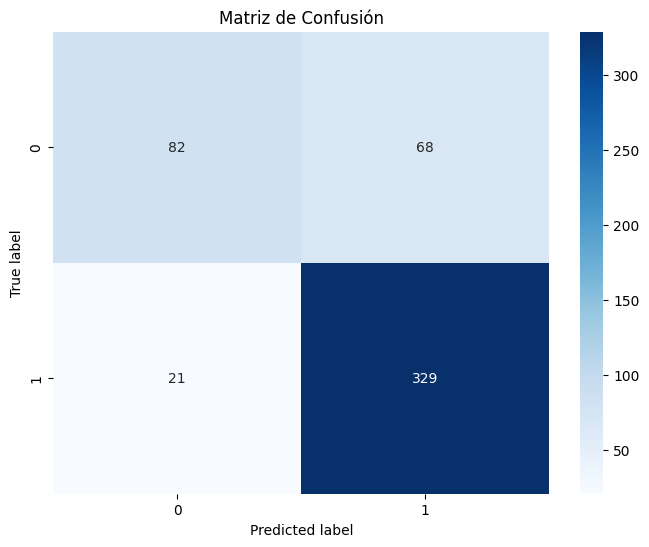

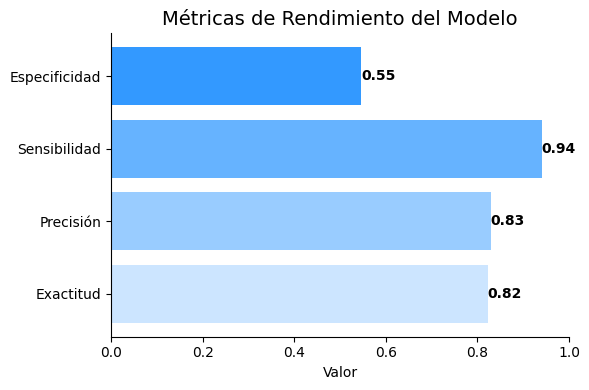

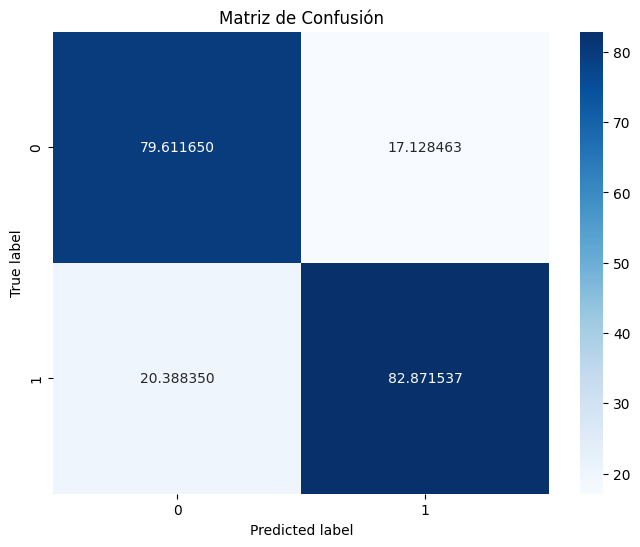

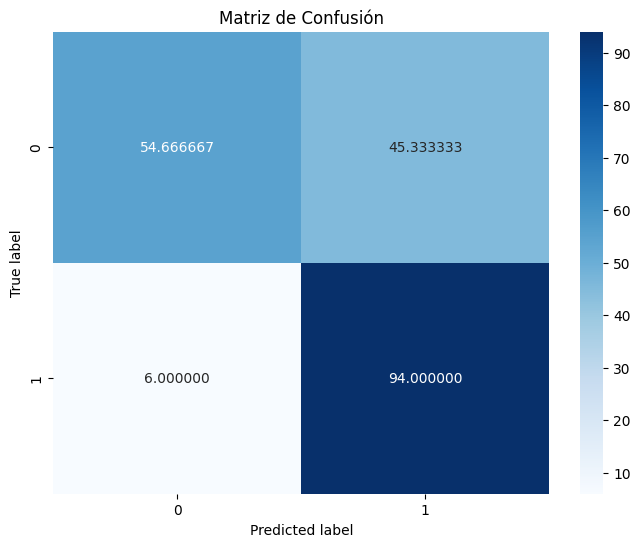

In [72]:
def cm_knn_model(k: int, x, y):
  """
  cm_knn_model:
  - k: Número de vecinos (k) para el algoritmo k-NN.
  - x, y: Conjuntos de características y etiquetas respectivamente.
  """
  # Construir y entrenar el clasificador k-NN
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(x, y)

  # Realizar predicciones
  y_pred = knn.predict(x)

  # Generar matriz de confusión
  return confusion_matrix(y, y_pred)

'''
Se llama a la función cm_knn_model con k=5 para obtener la matriz de confusión usando el conjunto de entrenamiento.
- Se visualiza la matriz de confusión con print_cm en formato entero ("d").
- Se calculan y muestran las métricas con print_stats.
- Se procesa la matriz de confusión para convertir los valores en porcentajes con process_cm.
- Finalmente, se vuelve a visualizar la matriz de confusión con los valores en formato decimal ("f").
'''
cm = cm_knn_model(5, X_train_scaled, Y_train)
print_cm(cm, "d")
print_stats(cm)
print_cm(percentage_predicted_cm(cm), "f")
print_cm(percentage_real_cm(cm), "f")

# Preguntas

## 1. Sobre el conjunto de entrenamiento, empleando la matriz de confusión la exactitud de un modelo lineal ¿es superior o inferior al 50%?:

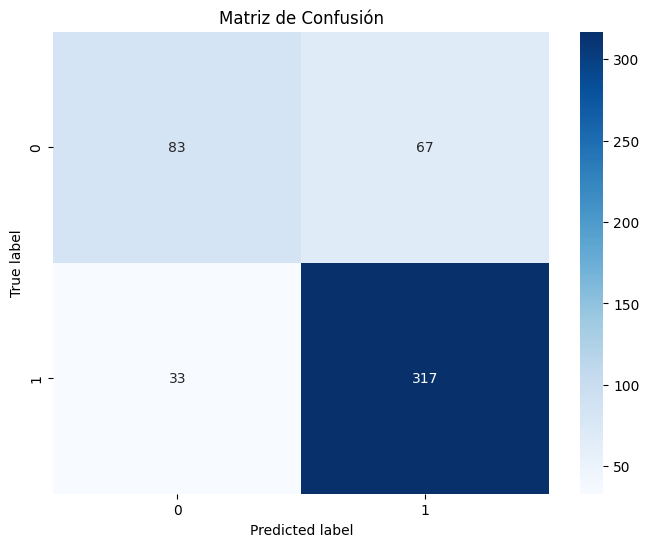

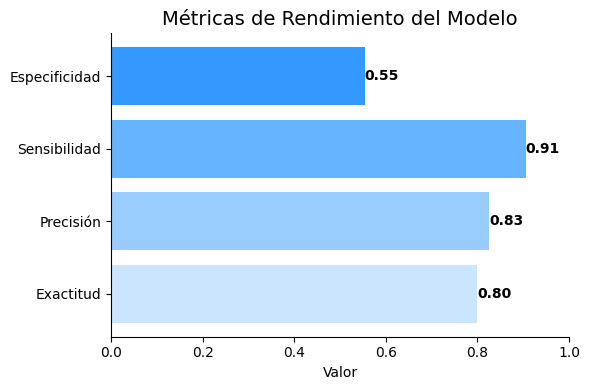

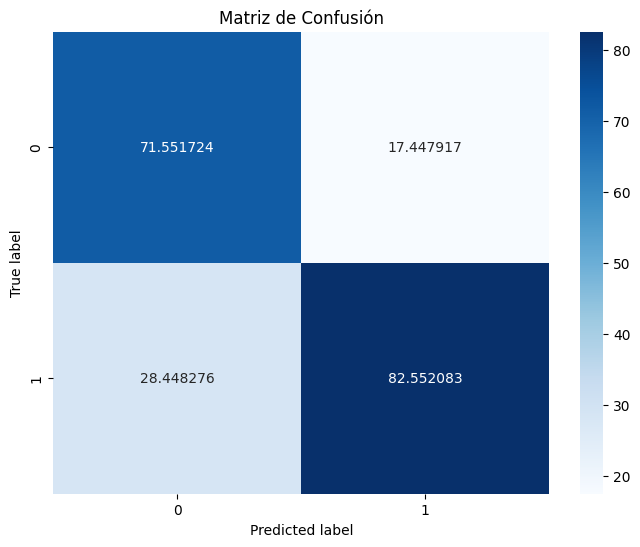

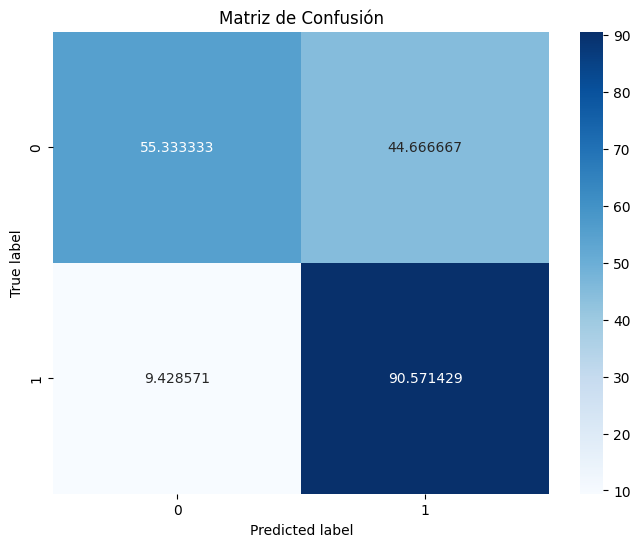

In [73]:
from sklearn.linear_model import LinearRegression

def cm_linear_regression(x, y):
  """
  cm_linear_regression:
  - x, y: Conjuntos de características y etiquetas respectivamente.
  """
  # Construir y entrenar el modelo lineal
  lr = LinearRegression()
  lr.fit(x, y)

  # Realizar predicciones y redondear (el resultado del modelo es continuo)
  y_pred = lr.predict(x)
  y_pred_rounded = [int(i > 0.5) for i in y_pred]  # Redondear predicciones

  # Generar matriz de confusión
  return confusion_matrix(y, y_pred_rounded)


"""
Se llama a la función cm_linear_regression para obtener la matriz de confusión con el modelo de regresión lineal.
- Se visualiza la matriz de confusión en formato entero ("d").
- Se calculan y muestran las métricas.
- Se procesa la matriz de confusión para convertir los valores en porcentajes y se visualiza en formato decimal ("f").
"""
cm = cm_linear_regression(X_train_scaled, Y_train)
print_cm(cm, "d")
print_stats(cm)
print_cm(percentage_predicted_cm(cm), "f")
print_cm(percentage_real_cm(cm), "f")

## 2. Sobre el mismo conjunto, cual es la exactitud de un modelo de regresión logística?

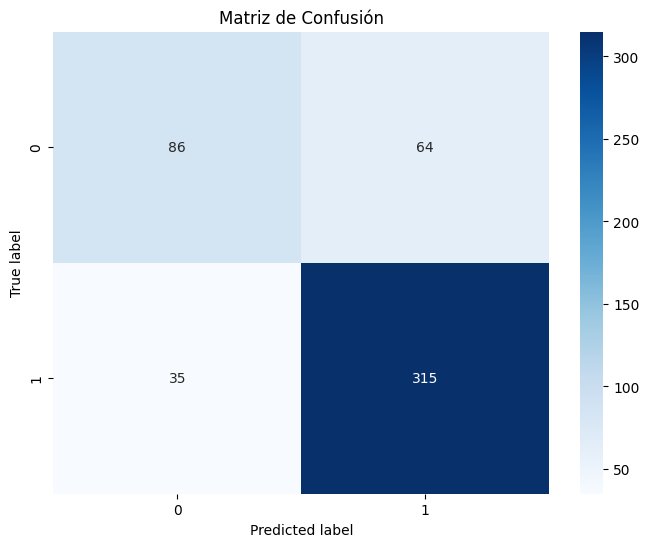

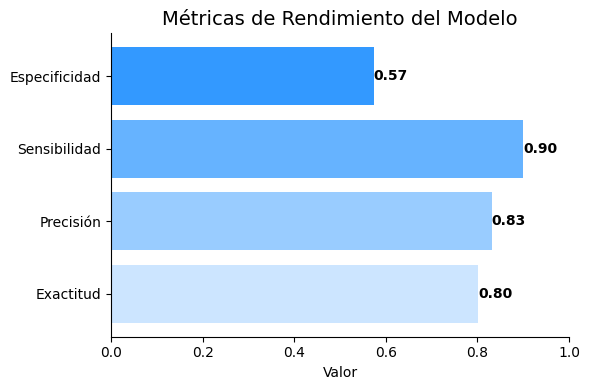

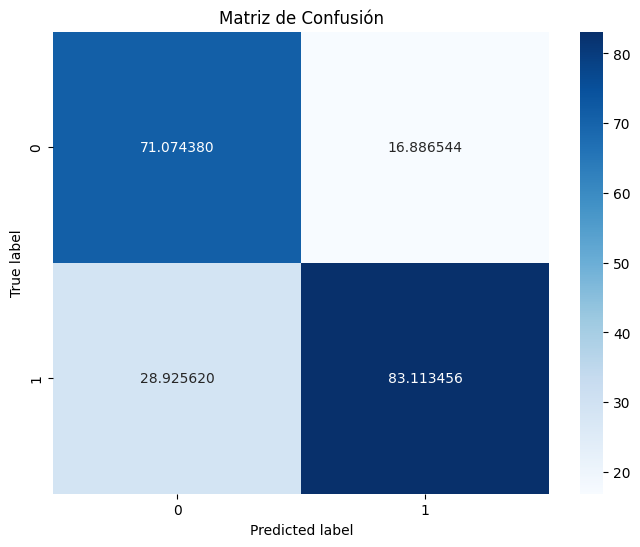

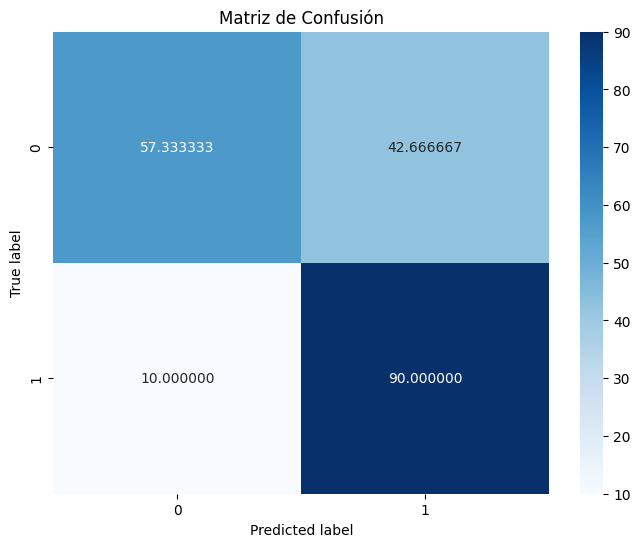

In [74]:
from sklearn.linear_model import LogisticRegression

def cm_logistic_regression(x, y):
  """
  cm_logistic_regression:
  - x, y: Conjuntos de características y etiquetas respectivamente.
  """
  # Construir y entrenar el modelo de regresión lógica
  lr = LogisticRegression()
  lr.fit(x, y)

  # Realizar predicciones
  y_pred = lr.predict(x)

  # Generar matriz de confusión
  return confusion_matrix(y, y_pred)


"""
Se llama a la función cm_logistic_regression para obtener la matriz de confusión usando el modelo de regresión logística.
- Se visualiza la matriz de confusión.
- Se calculan y muestran las métricas.
- Se procesa la matriz de confusión para convertir los valores en porcentajes y se visualiza en formato decimal.
"""
cm = cm_logistic_regression(X_train_scaled, Y_train)
print_cm(cm, "d")
print_stats(cm)
print_cm(percentage_predicted_cm(cm), "f")
print_cm(percentage_real_cm(cm), "f")


## 3. Sobre el mismo conjuntos de datos, empleando k-nn (10 vecinos) ¿cual es la exactitud del modelo?

La exactitud es de un 65%, no varía demasiado con un número de vecinos variable, pero cuanto más aumentan los vecinos empleados, aumentan tanto los verdaderos negativos como falsos positivos, aumentando muy ligeramente la exactitud.

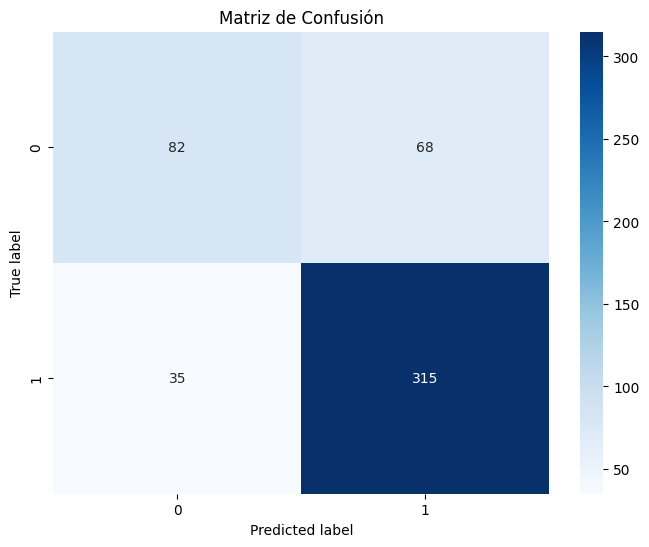

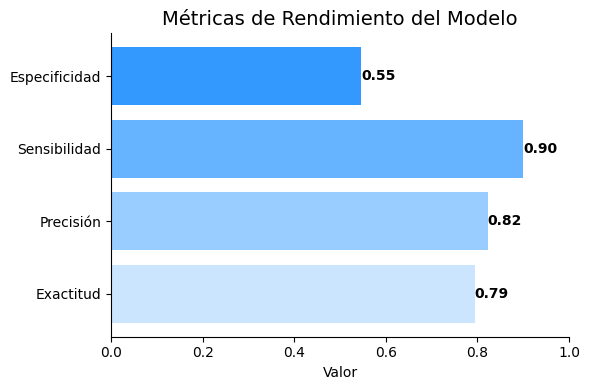

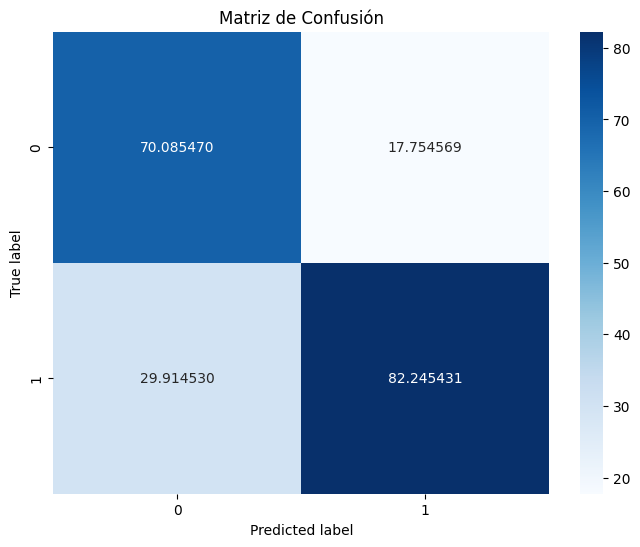

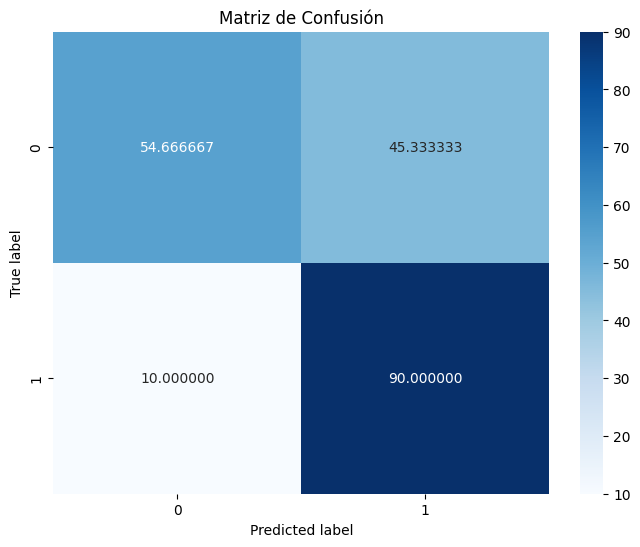

In [75]:
"""
Se realiza el mismo proceso con el modelo k-NN pero ahora utilizando k=10 (10 vecinos más cercanos) para la predicción.
- Se generan y visualizan las matrices de confusión y métricas.
"""
cm = cm_knn_model(10, X_train_scaled, Y_train)
print_cm(cm, "d")
print_stats(cm)
print_cm(percentage_predicted_cm(cm), "f")
print_cm(percentage_real_cm(cm), "f")

## 4. Misma pregunta para un árbol, permitiendo la máxima expansión por defecto.

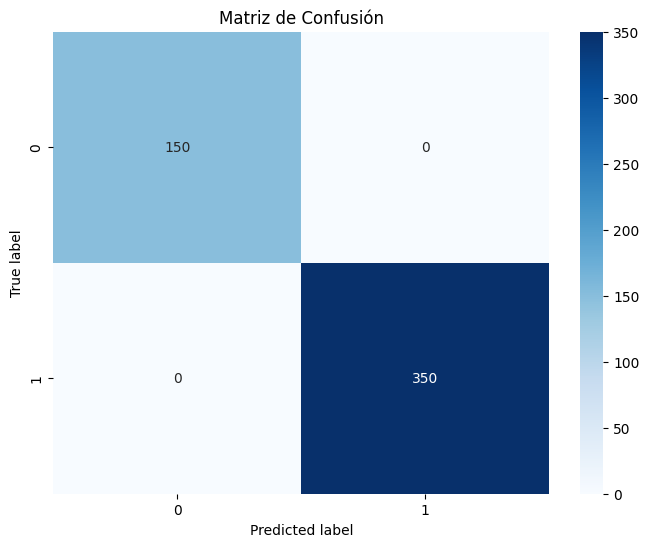

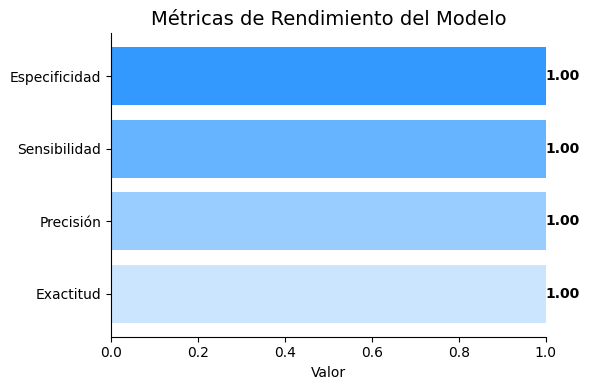

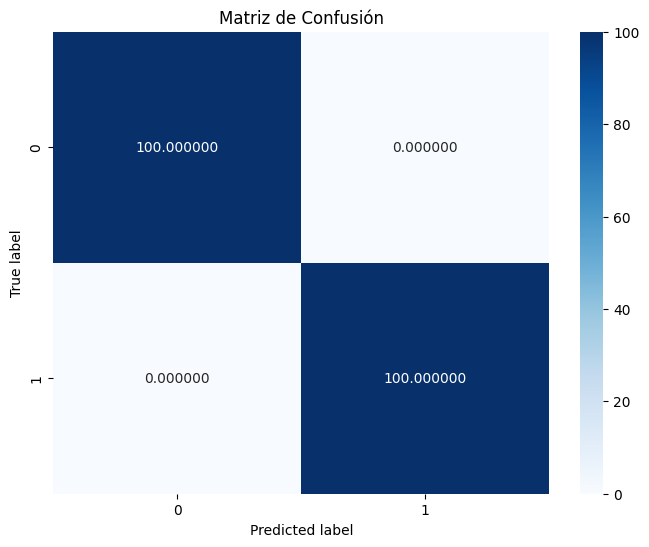

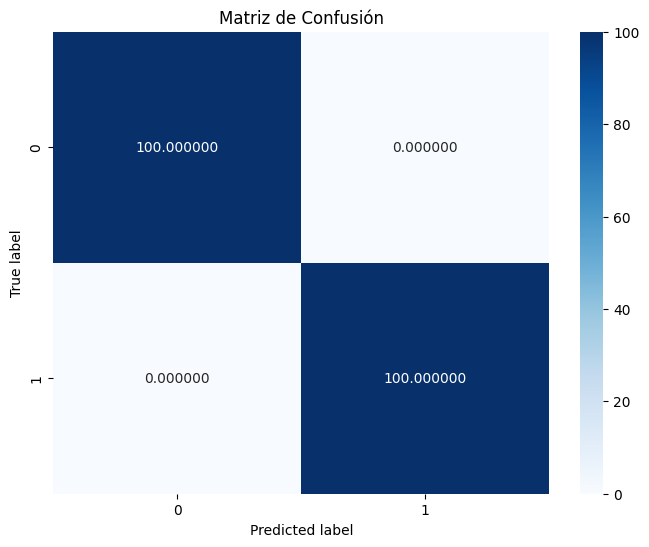

In [76]:
from sklearn.tree import DecisionTreeClassifier

def cm_tree_model(x, y):
  """
  cm_tree_model:
  - x, y: Conjuntos de características y etiquetas respectivamente.
  """
  # Construir y entrenar el modelo de árbol de decisión (sin limite)
  tree_model = DecisionTreeClassifier()
  tree_model.fit(x, y)

  # Realizar predicciones
  y_pred_tree = tree_model.predict(x)

  # Matriz confusión
  return confusion_matrix(y, y_pred_tree)


"""
Se llama a la función cm_tree_model para obtener la matriz de confusión con el modelo de árbol de decisión.
- Se visualiza la matriz de confusión.
- Se calculan y muestran las métricas.
- Se procesa la matriz de confusión para convertir los valores en porcentajes y se visualiza en formato decimal.
"""
cm = cm_tree_model(X_train_scaled, Y_train)
print_cm(cm, "d")
print_stats(cm)
print_cm(percentage_predicted_cm(cm), "f")
print_cm(percentage_real_cm(cm), "f")

## 5. Sobre el conjunto de test, ¿que modelos, en su caso, ofrecen mejor calidad predictiva que sobre el conjunto de entrenamiento?.
Emplee tres medidas
alternativas: exactitud, F1 y coeficiente de Matthews.

KNN de 5:
F1: 0.8016304347826086
MCC: 0.2579858909938019


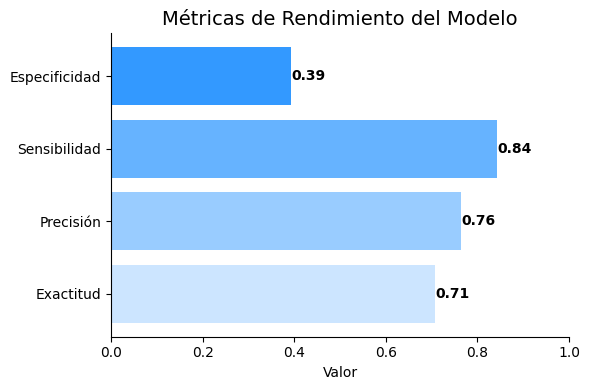


KNN de 10:
F1: 0.7932960893854749
MCC: 0.2739316457321619


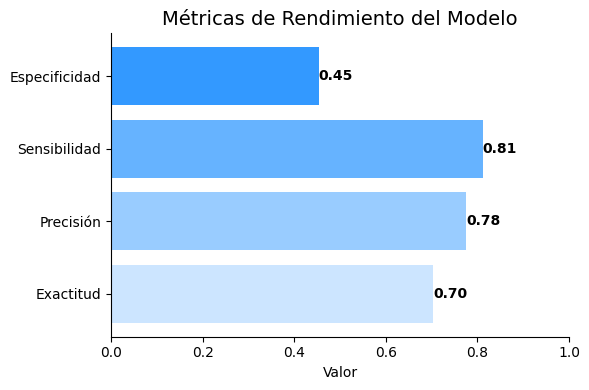


Modelo lineal:
F1: 0.7865497076023392
MCC: 0.3262163609272455


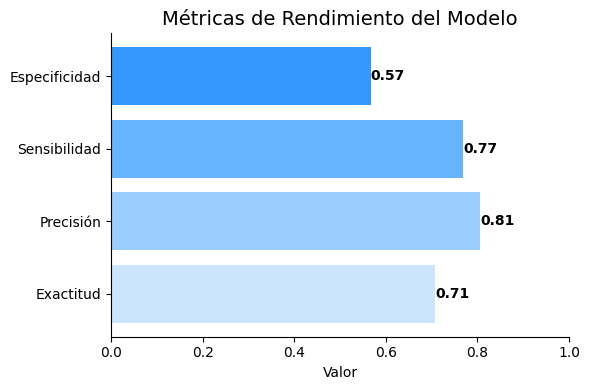


Regresión Logística:
F1: 0.7771260997067447
MCC: 0.30122032307174346


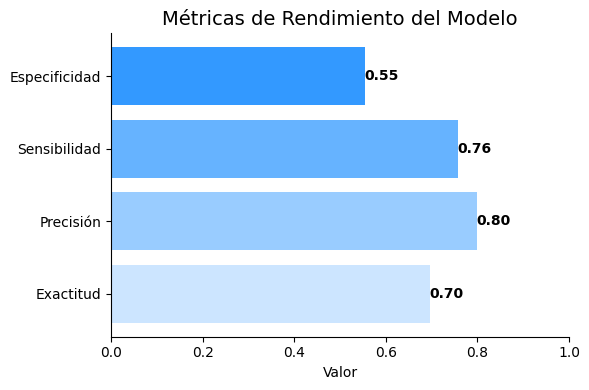


Árbol de Decisión:
F1: 0.7230769230769231
MCC: 0.22271770159368698


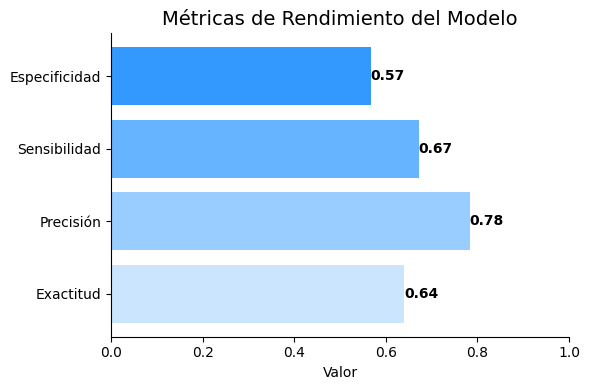

In [77]:
def F1_score(cm):
  """
  F1_score:
  - Calcula el puntaje F1, que es la media armónica entre la precisión y la sensibilidad (recall).
  - La precisión es la proporción de verdaderos positivos entre todas las predicciones positivas.
  - La sensibilidad es la proporción de verdaderos positivos entre todos los casos que son realmente positivos.
  - La fórmula es: 2 * (precisión * sensibilidad) / (precisión + sensibilidad).
  """

  TP = cm[1, 1]
  FP = cm[0, 1]
  TN = cm[0, 0]
  FN = cm[1, 0]

  precision = TP / (TP + FP)
  sensibilidad = TP / (TP + FN)

  return 2 * (precision * sensibilidad) / (precision + sensibilidad)


def MCC_score(cm):
  """
  MCC_score (Coeficiente de correlación de Matthews):
  - Calcula el coeficiente de correlación de Matthews (MCC), una métrica que toma en cuenta el equilibrio entre las clases, especialmente en casos de clases desbalanceadas.
  - La fórmula es: (TP * TN - FP * FN) / sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)).
  - MCC varía entre -1 y 1, donde 1 indica predicciones perfectas, 0 indica aleatorias y -1 indica que todas las predicciones son incorrectas.
  """
  TP = cm[1, 1]
  FP = cm[0, 1]
  TN = cm[0, 0]
  FN = cm[1, 0]

  res = (TP * TN - FP * FN)
  res /= np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

  return res



def test_quality(cm):
  """
  test_quality:
  - Esta función toma una matriz de confusión (cm) y calcula las métricas de calidad ( F1 y MCC), imprimiendo sus valores.
  """
  print(f"F1: {F1_score(cm)}")
  print(f"MCC: {MCC_score(cm)}")


"""
KNN de 5:
- Se utiliza el modelo k-NN con k=5 para hacer predicciones sobre el conjunto de prueba (X_test_scaled, Y_test).
- Se calcula la matriz de confusión y se evalúa el modelo usando las métricas (Exactitud, F1 y MCC).
"""
print("KNN de 5:")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, Y_train)
y_pred = knn.predict(X_test_scaled)
cm = confusion_matrix(Y_test, y_pred)
test_quality(cm)
print_stats(cm)

"""
KNN de 10:
- Se repite el proceso anterior, pero con k=10, para ver cómo cambia el rendimiento del modelo.
"""
print("\nKNN de 10:")
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, Y_train)
y_pred = knn.predict(X_test_scaled)
cm = confusion_matrix(Y_test, y_pred)
test_quality(cm)
print_stats(cm)

"""
Modelo lineal:
- Se evalúa el modelo de regresión lineal en el conjunto de prueba, utilizando las predicciones redondeadas.
- Se calcula la matriz de confusión y se evalúan las métricas.
"""
print("\nModelo lineal:")
lr = LinearRegression()
lr.fit(X_train_scaled, Y_train)
y_pred = lr.predict(X_test_scaled)
y_pred_rounded = [int(i > 0.5) for i in y_pred]
cm = confusion_matrix(Y_test, y_pred_rounded)
test_quality(cm)
print_stats(cm)

"""
Regresión Logística:
- Se entrena y evalúa el modelo de regresión logística, se calcula la matriz de confusión y se obtienen las métricas.
"""
print("\nRegresión Logística:")
lr = LogisticRegression()
lr.fit(X_train_scaled, Y_train)
y_pred = lr.predict(X_test_scaled)
cm = confusion_matrix(Y_test, y_pred)
test_quality(cm)
print_stats(cm)

"""
Árbol de Decisión:
- Finalmente, se entrena y evalúa un modelo de árbol de decisión con el conjunto de prueba.
- Se calcula la matriz de confusión y se obtienen las métricas de evaluación.
"""
print("\nÁrbol de Decisión:")
cart = DecisionTreeClassifier()
cart.fit(X_train_scaled, Y_train)
y_pred = cart.predict(X_test_scaled)
cm = confusion_matrix(Y_test, y_pred)
test_quality(cm)
print_stats(cm)

## 6. Suponga ahora que el coste de conceder un crédito (y que el cliente no lo devuelva) es el cuatro veces que el coste de no concederlo en el caso de en que un cliente sí lo hubiera devuelto. ¿en términos predictivos, que modelo parece el más adecuado?

Esto quiere decir que priorizamos reducir los falsos negativos, costando estos 4 veces más, veamos que modelo actúa mejor:

In [78]:
def test_cost(cm):
  """
  test_cost:
  - Calcula el coste asociado con las predicciones incorrectas del modelo.
  - El coste está basado en el supuesto de que los falsos positivos (FP, conceder un crédito a alguien que no lo devolverá) tienen un coste 4 veces mayor que los falsos negativos (FN, no conceder un crédito a alguien que lo devolvería).
  - La fórmula utilizada es: 4 * FP + FN.
  - La función toma una matriz de confusión (cm) y devuelve el coste total.
  """
  TP = cm[1,1]
  FP = cm[0,1]
  TN = cm[0,0]
  FN = cm[1,0]

  return 4*FP + FN

"""
Bloque de evaluación de costes:
- Se utiliza la función `test_cost` para calcular el coste de cada modelo en el conjunto de prueba (X_test_scaled, Y_test).
- Se imprimen los costes calculados para cada modelo:
  - KNN con k=5.
  - KNN con k=10.
  - Modelo de regresión lineal.
  - Regresión logística.
  - Árbol de decisión.
- El resultado muestra el coste total asociado a cada modelo, basándose en los falsos positivos y falsos negativos.
"""
print("Coste - Modelo")
print(f" {test_cost(cm_knn_model(5, X_test_scaled, Y_test))} - KNN de 5")
print(f" {test_cost(cm_knn_model(10, X_test_scaled, Y_test))} - KNN de 10")
print(f" {test_cost(cm_linear_regression(X_test_scaled, Y_test))} - Modelo lineal")
print(f" {test_cost(cm_logistic_regression(X_test_scaled, Y_test))} - Regresión Logística")
print(f" {test_cost(cm_tree_model(X_test_scaled, Y_test))} - Árbol de Decisión")


Coste - Modelo
 329 - KNN de 5
 333 - KNN de 10
 376 - Modelo lineal
 364 - Regresión Logística
 0 - Árbol de Decisión
